<a href="https://colab.research.google.com/github/rogargon/WikidataExtractor/blob/main/notebooks/wikidata_extractor.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Retrieve Entity Descriptions from Wikidata

Retrieve RDF for an entity (and its directly linked one) from Wikidata using SPARQL CONSTRUCT over the Wikidata SPARQL Endpoint.

## Install

Install Python packages rdflib and SPARQLWrapper

In [ ]:
!pip install rdflib SPARQLWrapper

## 2. Load Data from SPARQL Endpoint

Traverse Wikidata to retrieve resources of interest.

In [17]:
from rdflib import Graph as RDFGraph
from SPARQLWrapper import SPARQLWrapper, JSON
from string import Template

agent = "WikidataExtractor/0.1 (rogargon@gmail.com) SPARQLWrapper/1.8.5"
endpoint = "https://query.wikidata.org/sparql"
entity = "wd:Q82069695" #COVID19

query = Template('''SELECT *
WHERE {
  ?gene wdt:P703 ?entity .
  OPTIONAL { ?gene wdt:P684 ?ortholog_gene. }
  OPTIONAL { ?gene wdt:P682 ?biological_process. }
  OPTIONAL { ?gene wdt:P688 ?protein_encoded_by_gene. }
  OPTIONAL { ?gene wdt:P527 ?has_part. }
  OPTIONAL { ?gene wdt:P1057 ?chromosome. }
  OPTIONAL { ?disease wdt:P828 ?entity. }
  OPTIONAL { ?disease wdt:P780 ?symptoms. }
  OPTIONAL { ?disease wdt:P2293 ?associated_gene. }
  OPTIONAL { ?disease wdt:P927 ?anatomical_location. }
  OPTIONAL { ?disease wdt:P2176 ?drug_used_for_treatment. }
  BIND(wd:Q82069695 AS ?entity)
}''').substitute(e=entity)

sparql = SPARQLWrapper(endpoint, agent=agent)
sparql.setQuery(query)
sparql.setReturnFormat(JSON)
json = sparql.query().convert()

Process query result and keep all distinct entities.

In [27]:
entities = set()
for binding in json['results']['bindings']:
  for key in binding.keys():
    entities.add(binding[key]['value'])

print('Retrieved {} entities:'.format(len(entities)))
print(entities)

Retrieved 138 entities:
{'http://www.wikidata.org/entity/Q2603200', 'http://www.wikidata.org/entity/Q88088053', 'http://www.wikidata.org/entity/Q84263196', 'http://www.wikidata.org/entity/Q170082', 'http://www.wikidata.org/entity/Q22279537', 'http://www.wikidata.org/entity/Q90012261', 'http://www.wikidata.org/entity/Q104532904', 'http://www.wikidata.org/entity/Q188008', 'http://www.wikidata.org/entity/Q88105063', 'http://www.wikidata.org/entity/Q87917581', 'http://www.wikidata.org/entity/Q90081967', 'http://www.wikidata.org/entity/Q89006922', 'http://www.wikidata.org/entity/Q87917580', 'http://www.wikidata.org/entity/Q88088595', 'http://www.wikidata.org/entity/Q89792653', 'http://www.wikidata.org/entity/Q199615', 'http://www.wikidata.org/entity/Q88088888', 'http://www.wikidata.org/entity/Q720026', 'http://www.wikidata.org/entity/Q90038952', 'http://www.wikidata.org/entity/Q90082500', 'http://www.wikidata.org/entity/Q88174316', 'http://www.wikidata.org/entity/Q21110720', 'http://www.wik

Retrieve descriptions for every resource of interest.

In [20]:
from rdflib import Graph as RDFGraph
from SPARQLWrapper import SPARQLWrapper, RDFXML
from string import Template
import time

def extract_entity(entity):
  endpoint = "https://query.wikidata.org/sparql"
  agent = "WikidataExtractor/0.1 (rogargon@gmail.com) SPARQLWrapper/1.8.5"
  sparql = SPARQLWrapper(endpoint, agent=agent)
  sparql.setReturnFormat(RDFXML)
  entityId = entity.split('/')[-1][:-1]
  print('Processing entity {}...'.format(entityId))

  query = Template('''
  CONSTRUCT { ?s ?p ?o }
  WHERE {
    {
      ?s ?p ?o .
      BIND($e AS ?s)
      FILTER(!STRSTARTS(STR(?o), "http://www.wikidata.org/entity/statement/") &&
            !STRSTARTS(STR(?o), "http://www.wikidata.org/prop/novalue/"))
      FILTER(!ISLITERAL(?o) || !LANG(?o) || LANG(?o) = "en")
    } 
    UNION 
    {
      $e ?sp ?s .
      ?s ?p ?o .
      BIND(rdfs:label AS ?p)
      FILTER(!STRSTARTS(STR(?s), "http://www.wikidata.org/entity/statement/") &&
            !STRSTARTS(STR(?s), "http://www.wikidata.org/prop/novalue/"))
      FILTER(!ISLITERAL(?o) || !LANG(?o) || LANG(?o) = "en")    
    } 
    UNION 
    {
      ?s wdt:P31 ?o .
      BIND($e AS ?s)
      BIND(rdf:type AS ?p)   
    } 
  } 
  ''').substitute(e=entity)

  sparql.setQuery(query)
  sparql.setReturnFormat(RDFXML)
  response = sparql.query()
  rdf = response.convert()

  filename = entityId + '.ttl'
  rdf.serialize(destination='/content/extraction/'+filename, format="turtle")
  print("{} triples writen to file {}".format(len(rdf), filename))

  if 'retry-after' in response.info().keys():
    print('Continuing after {}...'.format(response.info()['retry-after']))
    time.sleep(response.info()['retry-after'])

  queryOnto = Template('''
  CONSTRUCT { ?s ?p ?o }
  WHERE {
    {
      $e wdt:P31 ?s .
      ?s ?p ?o .
      BIND(rdfs:label AS ?p)
      FILTER(!LANG(?o) || LANG(?o) = "en") 
    }
    UNION
    {
      $e ?s ?so .
      ?wd wikibase:directClaim|wikibase:directClaimNormalized ?s .
      ?wd ?p ?o .
      BIND(rdfs:label AS ?p)
      FILTER(!STRSTARTS(STR(?so), "http://www.wikidata.org/entity/statement/") &&
            !STRSTARTS(STR(?so), "http://www.wikidata.org/prop/novalue/"))
      FILTER(!ISLITERAL(?o) || !LANG(?o) || LANG(?o) = "en")
    } 
  } 
  ''').substitute(e=entity)

  sparql.setQuery(queryOnto)
  response = sparql.query()
  rdf = response.convert()

  filename = entityId + '.onto.ttl'
  rdf.serialize(destination='/content/extraction/ontology/'+filename, format="turtle")
  print("{} triples writen to file {}".format(len(rdf), filename))

  if 'retry-after' in response.info().keys():
    print('Continuing after {}...'.format(response.info()['retry-after']))
    time.sleep(response.info()['retry-after'])

In [ ]:
!mkdir '/content/extraction'
!mkdir '/content/extraction/ontology'

for entity in entities:
  extract_entity('<'+entity+'>')

#extract_entity('wd:Q82069695')

In [ ]:
!zip -r /content/extraction.zip /content/extraction/

from google.colab import files
files.download("/content/extraction.zip")

## Draw RDF using graph_tool.Graph

Install APT packages for graph-tool

In [ ]:
!echo "deb http://downloads.skewed.de/apt bionic main" >> /etc/apt/sources.list
!apt-key adv --keyserver keys.openpgp.org --recv-key 612DEFB798507F25
!apt-get update
!apt-get install python3-graph-tool python3-cairo python3-matplotlib

Load all extraction files for instance data into one RDFLib graph.
Then, all the files for onto data into a separate graph.
Finally, generate a third graph combining both.


In [ ]:
from rdflib import Graph
import os

rdf = Graph()
folder = '/content/extraction/'
countI = 0
for root, dirs, files in os.walk(folder):
    for name in files:
      if name.endswith('.ttl') and not(name.endswith('onto.ttl')):
          print('Loading {}...'.format(os.path.join(root, name)))
          rdf.parse(os.path.join(root, name), format='ttl')
          countI = countI + 1

ontology = Graph()
folder = '/content/extraction/'
countO = 0
for root, dirs, files in os.walk(folder):
    for name in files:
      if name.endswith('onto.ttl'):
          print('Loading {}...'.format(os.path.join(root, name)))
          ontology.parse(os.path.join(root, name), format='ttl')
          countO = countO + 1

print('Loaded {} triples from {} files into instance graph'.format(len(rdf), countI))
print('Loaded {} triples from {} files into ontology graph'.format(len(ontology), countO))
combined = rdf + ontology
print('Combined graph contains {} triple '.format(len(combined)))

Convert the instance data RDFLib graph to graph-tool Graph using [rdflib/extras/external_graph_libs](https://github.com/RDFLib/rdflib/blob/master/rdflib/extras/external_graph_libs.py). 

Generate labels for nodes and edges intead of their URIs using the RDF graph combining the instance and ontology data.

In [ ]:
from rdflib.extras.external_graph_libs import rdflib_to_graphtool
import graph_tool as gt
import textwrap

# Define node and edge labels based or RDF preferred labels or the URI fragment
def label(term, rdf):
  labels = rdf.preferredLabel(term, lang="en")
  if len(labels) > 0:
    return labels[0][1]
  else:
    fragment = term.split('/')[-1]
    return textwrap.shorten(fragment, width=20, placeholder="...")

# Conversion of rdflib.Graph to graph_tool.Graph
g = rdflib_to_graphtool(rdf, 
      transform_s=lambda s, p, o: {str("term"): label(s, combined)},
      transform_p=lambda s, p, o: {str("term"): label(p, combined)},
      transform_o=lambda s, p, o: {str("term"): label(o, combined)})
print(g)

Draw graph using the sfdp layout. Other options available from:
https://graph-tool.skewed.de/static/doc/draw.html

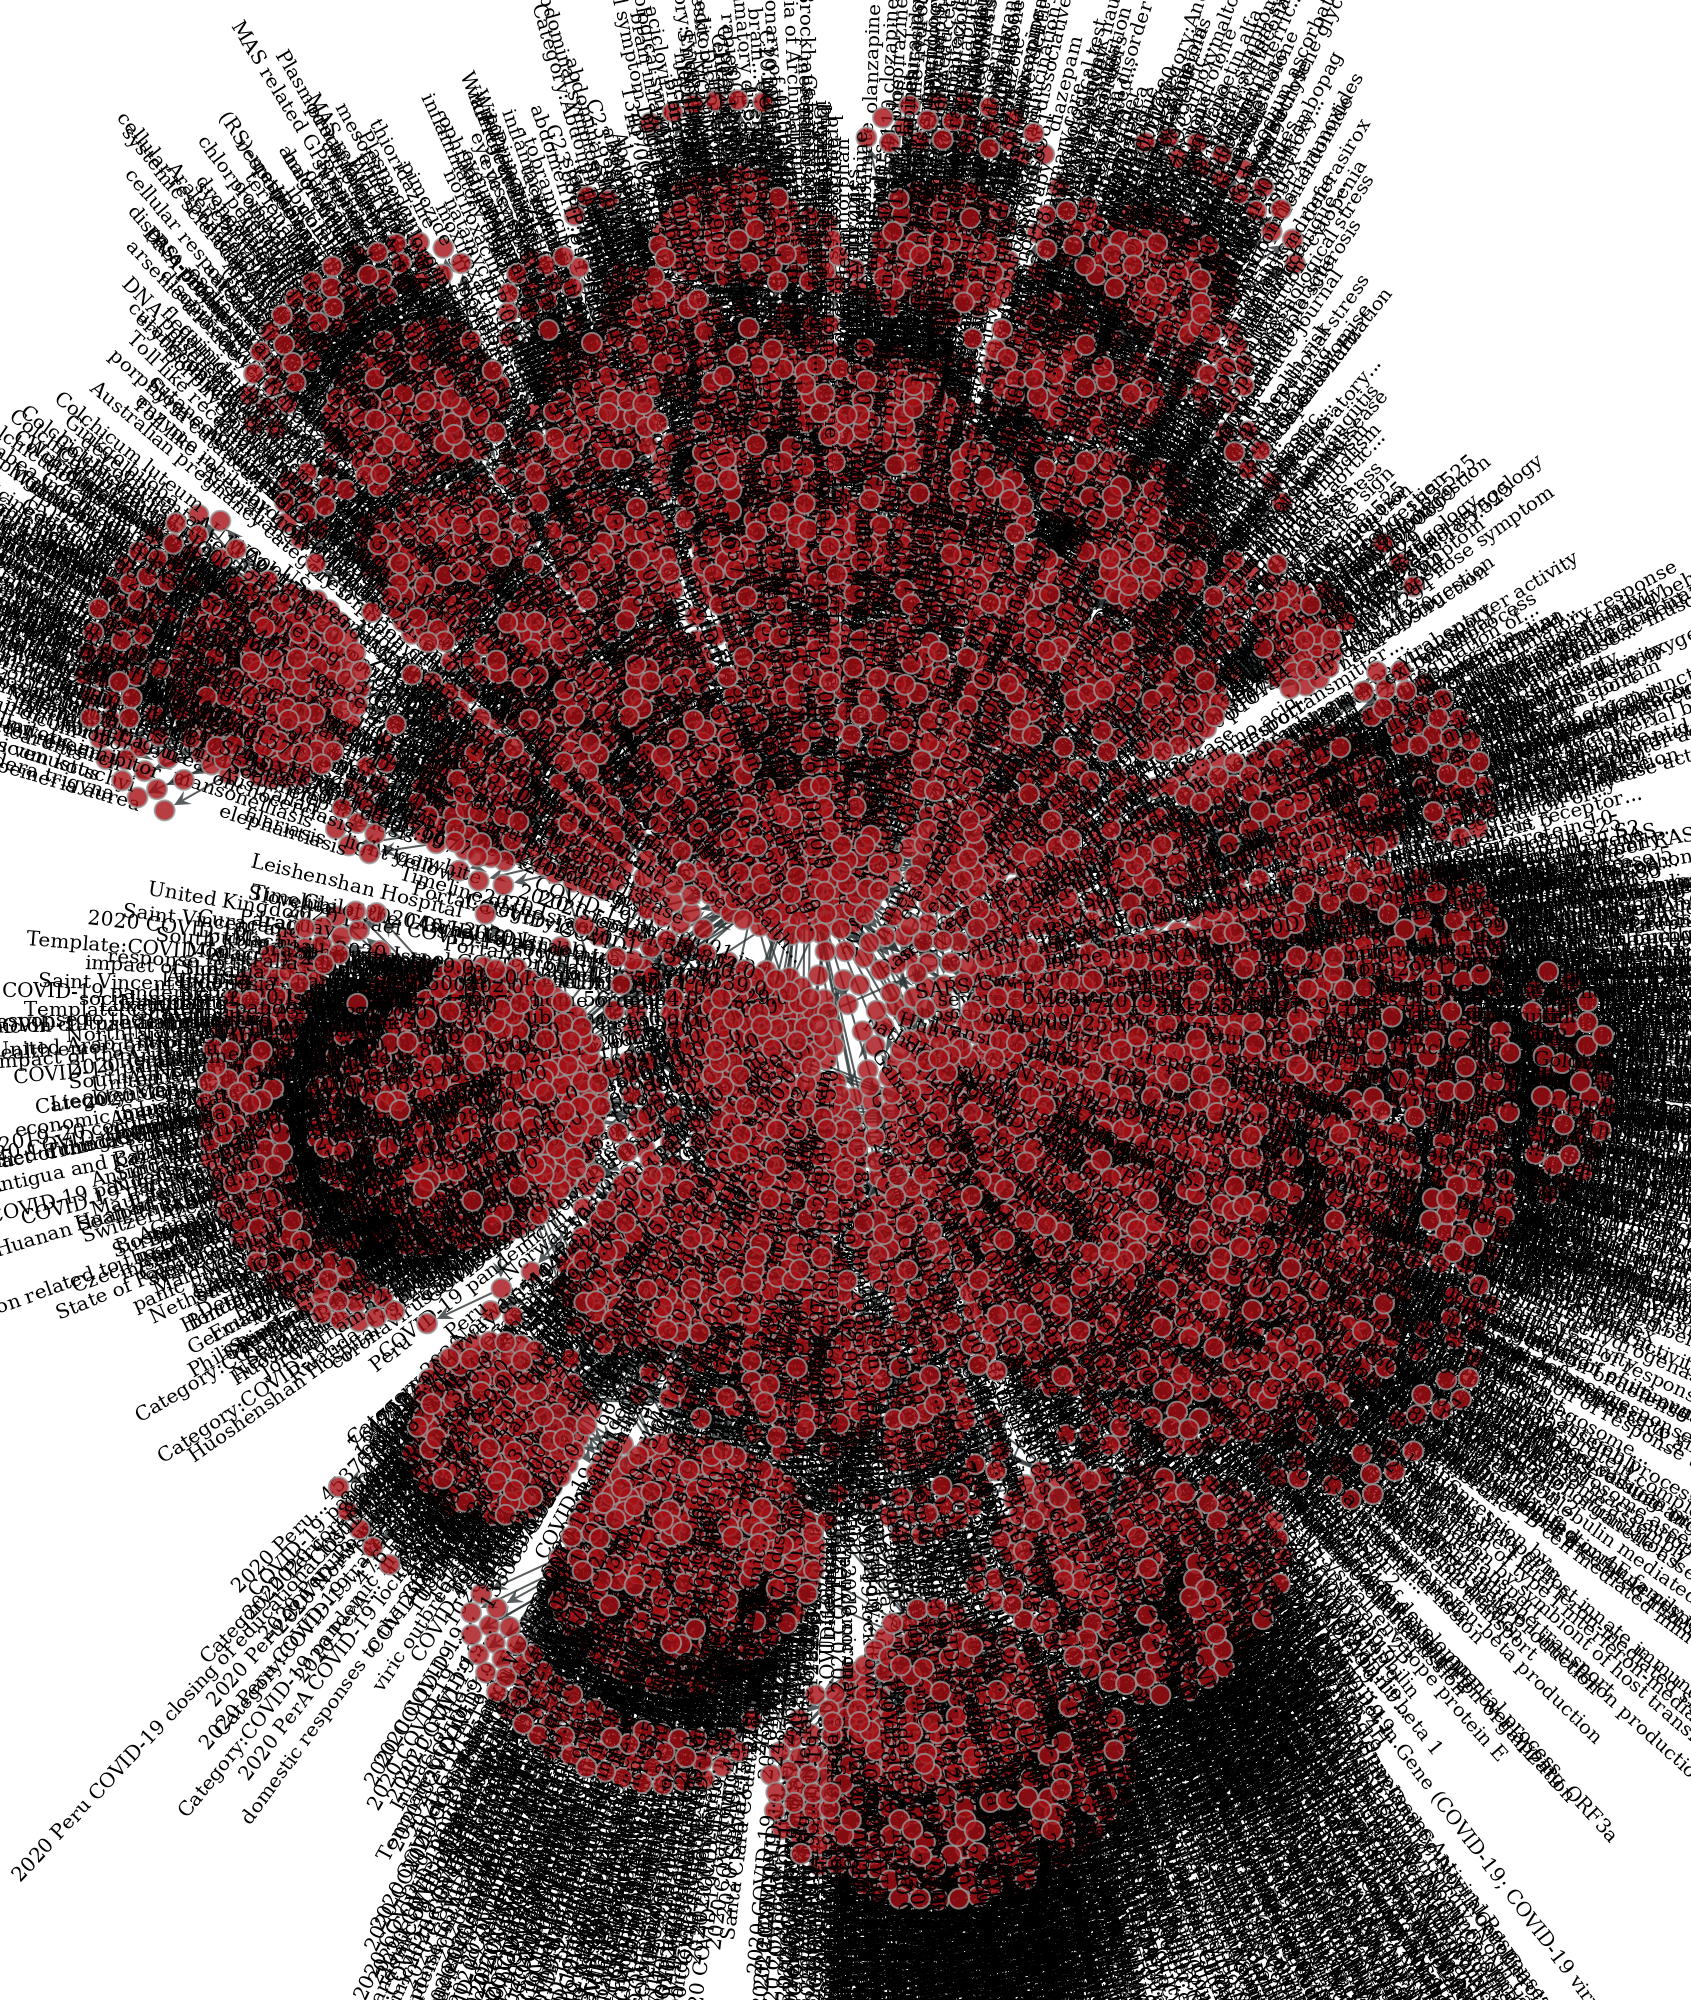

In [67]:
from graph_tool.all import sfdp_layout, graph_draw

#pos = sfdp_layout(g)
pos = graph_draw(g, output_size=(1000, 1000), pos=pos,
           vertex_text=g.vp.term, vertex_text_position="centered", vertex_font_size=10, vertex_size=10)
#           edge_text=g.ep.term, edge_font_size=6)
